## Emotion Detection

## Loading dataset

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_pickle('merged_training.pkl')

In [21]:
df.head(15)

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
18231,i find myself frustrated with christians becau...,love
10714,i am one of those people who feels like going ...,joy
35177,i feel especially pleased about this as this h...,joy
122177,i was struggling with these awful feelings and...,joy
26723,i feel so enraged but helpless at the same time,anger


In [22]:
len(df.index)

416809

In [23]:
# Display the distribution of emotions
emotion_counts = df['emotions'].value_counts()
print(emotion_counts)

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64


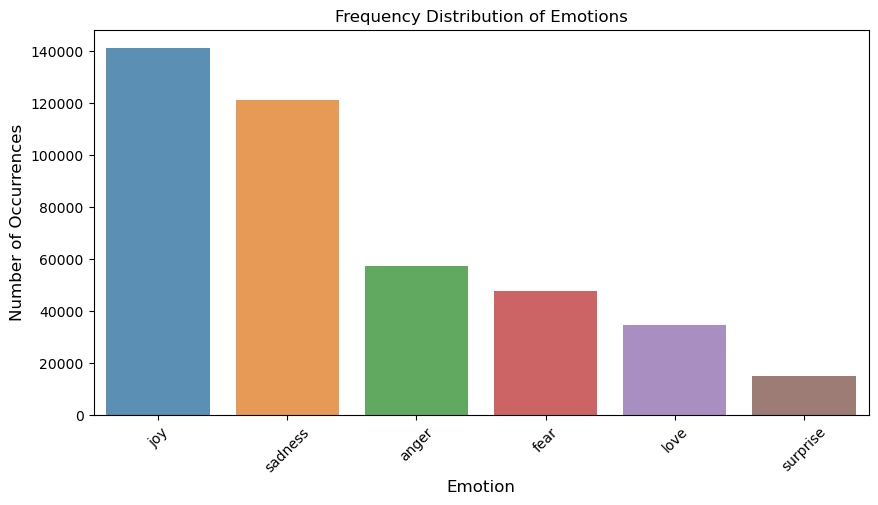

In [24]:
# Plotting the distribution of emotions
plt.figure(figsize=(10, 5))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, alpha=0.8)
plt.title('Frequency Distribution of Emotions')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Emotion', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [25]:
min_emotion_count = emotion_counts.min()
min_emotion = emotion_counts.idxmin()
print(min_emotion, min_emotion_count)

surprise 14972


the dataset is very skew. it should be split equally among the rest. we can Stratified Split(cite) to split dataset equally.


but first we should convert text to number so the ml model can process it

In [26]:
# import required module
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# get tf-df values
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])


In [27]:
y = df['emotions']

In [28]:
X_tfidf

<416809x74964 sparse matrix of type '<class 'numpy.float64'>'
	with 3396200 stored elements in Compressed Sparse Row format>

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Model

## Naive Bayes

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
naive_bayes_classifier = MultinomialNB()

# Train the classifier
naive_bayes_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = naive_bayes_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7666682661164559
              precision    recall  f1-score   support

       anger       0.93      0.64      0.76     11463
        fear       0.90      0.48      0.63      9542
         joy       0.71      0.97      0.82     28214
        love       0.95      0.24      0.38      6911
     sadness       0.76      0.94      0.84     24238
    surprise       0.97      0.08      0.14      2994

    accuracy                           0.77     83362
   macro avg       0.87      0.56      0.59     83362
weighted avg       0.81      0.77      0.73     83362



In [31]:
import joblib

# Save the model
joblib.dump(naive_bayes_classifier, 'naive_bayes_model.pkl')

# Save the vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

## Linear Regression

In [32]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
# Using 'liblinear' solver for binary classification and 'saga' for multiclass
logreg = LogisticRegression(solver='saga', max_iter=1000,random_state=42)

# Train the model
logreg.fit(X_train, y_train)

# Predict on the test data
y_pred_logreg = logreg.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
report_logreg = classification_report(y_test, y_pred_logreg)

In [33]:
accuracy_logreg

0.8896619562870373

In [34]:
print(report_logreg)

              precision    recall  f1-score   support

       anger       0.89      0.90      0.90     11463
        fear       0.84      0.83      0.84      9542
         joy       0.90      0.93      0.91     28214
        love       0.79      0.74      0.77      6911
     sadness       0.94      0.93      0.93     24238
    surprise       0.75      0.69      0.72      2994

    accuracy                           0.89     83362
   macro avg       0.85      0.84      0.84     83362
weighted avg       0.89      0.89      0.89     83362



In [35]:
joblib.dump(logreg, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

## CNN

In [36]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

K.clear_session()
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=100)

# Prepare the labels 
y = pd.get_dummies(df['emotions']).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           12320     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 10)                16010     
                                                                 
 dense_1 (Dense)             (None, 6)                 66        
                                                        

In [38]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [39]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Model checkpoint to save the model after every epoch
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Early stopping to stop training when the validation loss does not decrease for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.2, min_lr=0.00001, verbose=1)

# Including these callbacks in the model's fit method
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[checkpoint, early_stopping, reduce_lr])


Epoch 1/10
5206/5211 [============================>.] - ETA: 0s - loss: 0.3762 - accuracy: 0.8509
Epoch 1: val_loss improved from inf to 0.18887, saving model to model.h5
5211/5211 [==============================] - 37s 7ms/step - loss: 0.3761 - accuracy: 0.8510 - val_loss: 0.1889 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 2/10
5210/5211 [============================>.] - ETA: 0s - loss: 0.1643 - accuracy: 0.9239
Epoch 2: val_loss improved from 0.18887 to 0.16805, saving model to model.h5
5211/5211 [==============================] - 34s 7ms/step - loss: 0.1643 - accuracy: 0.9239 - val_loss: 0.1680 - val_accuracy: 0.9198 - lr: 0.0010
Epoch 3/10
5204/5211 [============================>.] - ETA: 0s - loss: 0.1457 - accuracy: 0.9282
Epoch 3: val_loss improved from 0.16805 to 0.16208, saving model to model.h5
5211/5211 [==============================] - 35s 7ms/step - loss: 0.1457 - accuracy: 0.9281 - val_loss: 0.1621 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 4/10
5208/5211 [================

In [40]:
import pickle

# Saving the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('CNN.h5')

# Application

In [41]:
import joblib
import keras
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
import pickle
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

def preprocess_text(text,tokenizer):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=100)  
    return padded_sequences
def main():
    # Load necessary model
    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    naive_bayes_model = joblib.load('naive_bayes_model.pkl')
    logreg = joblib.load('logistic_regression_model.joblib')
    CNN = keras.models.load_model('CNN.h5')

    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    index_to_emotion = {
    0: 'anger',
    1: 'fear',
    2: 'joy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
      }

    text=input("Enter your text here:")

    # preprocess text
    processed_text = preprocess_text(text,tokenizer)
    text_vector = vectorizer.transform([text])

    prediction_naive_bayes = naive_bayes_model.predict(text_vector)
    probabilities_naive_bayes = naive_bayes_model.predict_proba(text_vector)

    prediction_logreg = logreg.predict(text_vector)
    probabilities_logreg = logreg.predict_proba(text_vector)

    prediction_CNN = CNN.predict(processed_text)
    emotion_index = np.argmax(prediction_CNN)
    emotion_label = index_to_emotion[emotion_index]

    print("\nPredictions and Probabilities:\n")
    print("Naive Bayes Prediction: ", prediction_naive_bayes[0])
    print("Naive Bayes Probabilities: ")
    for i in range(len(probabilities_naive_bayes[0])):
        print(f"{index_to_emotion[i]}:{probabilities_naive_bayes[0][i]} ")
    print("\nLogistic Regression Prediction: ", prediction_logreg[0])
    for i in range(len(probabilities_logreg[0])):
        print(f"{index_to_emotion[i]}:{probabilities_logreg[0][i]} ")
    print("\nCNN Prediction (Emotion): ", emotion_label)
    for i in range(len(prediction_CNN[0])):
        print(f"{index_to_emotion[i]}:{prediction_CNN[0][i]} ")

if __name__ == "__main__":
    main()


Enter your text here:I slammed my fist in anger, but then burst into laughter, realizing the absurdity of it all.
1/1 [==============================] - 0s 38ms/step

Predictions and Probabilities:

Naive Bayes Prediction:  joy
Naive Bayes Probabilities: 
anger:0.2190863061281364 
fear:0.1388256211466991 
joy:0.26072114153468845 
love:0.11434620221122123 
sadness:0.24181941676627788 
surprise:0.02520131221297537 

Logistic Regression Prediction:  anger
anger:0.4017210688862057 
fear:0.12184924117849924 
joy:0.23832651889324377 
love:0.06885038501146967 
sadness:0.1315110941870479 
surprise:0.03774169184353367 

CNN Prediction (Emotion):  anger
anger:0.5735710859298706 
fear:0.19589252769947052 
joy:0.05969538912177086 
love:0.0007390704704448581 
sadness:0.1674700677394867 
surprise:0.0026317897718399763 
